<a href="https://colab.research.google.com/github/frnunez/SU-Grad-Portfolio/blob/master/IST%20652%20-%20Scripting%20for%20Data%20Analysis%20-%20DCA%20Inspections/IST652%20Project%20-%20DCA%20Inspections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Install Libraries
import os
import requests
import csv

%pip install pandas==2.2
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
#import sys

%pip install plotnine
from plotnine import * # pip install plotnine
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap

%pip install folium
import folium
import webbrowser

%pip install matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
#import warnings
#warnings.simplefilter('ignore')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [32]:
# NYC Data code uses the Socrata Open Data API
# We will load the API and file with the API supplied by Socrata
# Code Provided by Socrata

%pip install sodapy
from sodapy import Socrata # pip install sodapy
client = Socrata("data.cityofnewyork.us",
                 None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

'''
#####----- DCA Inspections Database (New York City Inspections) -----#####
#####----- https://data.cityofnewyork.us/Business/Inspections/jzhd-m6uv
'''

# Using the Socrata code, I pulled in the data into the "inspectionresults" dictionary
# You can set the limit as low as needed, at 1M I was able to pull in all the available data
# Data was returned as JSON from API / converted to Python list of dictionaries by sodapy.

inspectionresults = client.get("jzhd-m6uv", limit=1000000)
infile = inspectionresults

Note: you may need to restart the kernel to use updated packages.


In [33]:
# Convert to Dictionary into a Pandas DataFrame to analyze the data
inspections_df = pd.DataFrame.from_records(inspectionresults)

# I created a few variables in order to display some information about the data I just pulled in
# and display those results
nrows = len(inspections_df)
size = inspections_df.size
ncols = int(size/nrows)
print("*"*80)
print ("You loaded a total of", nrows, "records into your dataframe.")
print ("You have", nrows, "rows and", ncols ,"columns. Total data points is", size)
print("*"*80)
inspections_df.head(5)

********************************************************************************
You loaded a total of 660265 records into your dataframe.
You have 660265 rows and 18 columns. Total data points is 11884770
********************************************************************************


,record_id,certificate_number,business_name,inspection_date,inspection_result,industry,borough,building_number,street,city,state,zip,longitude,latitude,unit_type,unit,description,street_2
0,16005-2019-ENFO,05439358,STAY FRESH DELI & GRILL CORP.,2019-03-14T00:00:00.000,Violation Issued,Grocery-Retail - 808,Brooklyn,1695A,BROADWAY,BROOKLYN,NY,11207,-73.91210318943877,40.68385099919841,NaN,NaN,NaN,NaN
1,62345-2018-ENFO,03090119,DOWNTOWN BRONX DELI CORP.,2018-12-07T00:00:00.000,Pass,Grocery-Retail - 808,Bronx,622,MELROSE AVE,BRONX,NY,10455,-73.91695529015703,40.81784221938955,NaN,NaN,NaN,NaN
2,52836-2019-ENFO,09466854,"SHIM, JAE TAEK",2019-10-04T00:00:00.000,Out of Business,Misc Non-Food Retail - 817,Queens,7952,ALBION AVE,ELMHURST,NY,11373,-73.88438838883718,40.73925152076001,NaN,NaN,NaN,NaN
3,2078462-DCA,09444093,JZ CLEANERS 2 INC,2018-12-10T00:00:00.000,Warning,Laundries,Manhattan,365,E 62ND ST,NEW YORK,NY,10065,-73.96127770301152,40.761782524350295,NaN,NaN,NaN,NaN
4,23282-2020-ENFO,A0006625,OFFICE SUPERSTORE EAST LLC,2020-09-22T00:00:00.000,No Warning Issued,Misc Non-Food Retail - 817,Manhattan,641,6TH AVE,NEW YORK,NY,10011,-77.51985459193568,40.112489624577165,NaN,NaN,NaN,NaN


In [34]:
#####-----     Data Cleanup/Corrections     -----#####

# In addition to the inspections_df, I have an original version of the data for since I will be cleaning up the insections_df
originaldata = pd.DataFrame.from_records(inspectionresults)

###--- DROP COLUMNS ---###
# Drop Junk Columns
inspections_df = inspections_df.drop(['description', 'unit_type', 'unit', 'street_2'], axis=1)

# Drop Columns of Data I will not be using
inspections_df = inspections_df.drop(['certificate_number', 'building_number', 'street', 'city', 'state', 'zip'], axis=1)

#--- DROP NAs ---#
inspections_df = inspections_df.dropna(axis = 0, how ='any') 

###--- DATE ---###
#Convert Date column
inspections_df['inspection_date'] = pd.to_datetime(inspections_df['inspection_date'])

#Adding Year, Month and Weekday as categorical columns
inspections_df['yrmon'] = (inspections_df['inspection_date'].dt.strftime('%Y-%m')).astype('category')
inspections_df['year'] = (inspections_df['inspection_date'].dt.year).astype('category')
inspections_df['month'] = (inspections_df['inspection_date'].dt.month).astype('category')
inspections_df['weekday'] = (inspections_df['inspection_date'].dt.day_name()).astype('category')
inspections_df['inspection_date'] = inspections_df['inspection_date'].dt.strftime('%Y-%m-%d')

###--- Inspections & Violations ---###
# Rename Confiscated Licenses
inspections_df.inspection_result = inspections_df.inspection_result.replace({"Confiscated": "License Confiscated"})

# new column to categorize inspection results as violation or no violation
inspections_df = inspections_df.assign(violation = inspections_df['inspection_result'])
inspections_df.violation = inspections_df.violation.replace({"License Confiscated": "Violation Issued"})
inspections_df.loc[inspections_df["violation"] != "Violation Issued", "violation"] = "No Violation"
inspections_df['violation'].astype('category')

###--- BOROUGH DATA---###

# The borough data had duplicates caused by some borough names being in ALL Caps. The code below replaces
# the versions with spelling differences
inspections_df.borough = inspections_df.borough.replace({"MANHATTAN": "Manhattan",
                                                   "BRONX": "Bronx",
                                                   "QUEENS": "Queens",
                                                   "BROOKLYN": "Brooklyn"})

###--- Lat/Lon converted into float data type ---###
inspections_df['latitude'] = inspections_df['latitude'].astype(float)
inspections_df['longitude'] = inspections_df['longitude'].astype(float)

###--- License Categories ---###

# Some licensing categories had recent changes to the names of the categories. Since the data is from 
# multiple years, this code will change will change the name of these categories to the most recent
# license category name
inspections_df.industry = inspections_df.industry.replace({"Cigarette Retail Dealer - 127": "Tobacco Retail Dealer",
                                                           "Laundry - 064": "Laundries",
                                                           "Laundry Jobber - 066": "Laundries"})

# Add code to I can have information on my recent changes
# for comparison to the original data
nrows = len(inspections_df)
size = inspections_df.size
ncols = int(size/nrows)
orows = len(originaldata)
osize = originaldata.size
ocols = int(osize/orows)

# Display results
print("*"*80)
print("You had", orows, "with", ocols, "columns and", osize, "datapoints.")
print ("You now have", nrows, "rows and", ncols ,"columns. Total data points is", size)
print ("You dropped",(orows-nrows),"rows")
print("*"*80)
print(inspections_df.dtypes)
inspections_df.head(5)

********************************************************************************
You had 660265 with 18 columns and 11884770 datapoints.
You now have 619427 rows and 13 columns. Total data points is 8052551
You dropped 40838 rows
********************************************************************************
record_id              object
business_name          object
inspection_date        object
inspection_result      object
industry               object
borough                object
longitude             float64
latitude              float64
yrmon                category
year                 category
month                category
weekday              category
violation              object
dtype: object


,record_id,business_name,inspection_date,inspection_result,industry,borough,longitude,latitude,yrmon,year,month,weekday,violation
0,16005-2019-ENFO,STAY FRESH DELI & GRILL CORP.,2019-03-14,Violation Issued,Grocery-Retail - 808,Brooklyn,-73.912103,40.683851,2019-03,2019,3,Thursday,Violation Issued
1,62345-2018-ENFO,DOWNTOWN BRONX DELI CORP.,2018-12-07,Pass,Grocery-Retail - 808,Bronx,-73.916955,40.817842,2018-12,2018,12,Friday,No Violation
2,52836-2019-ENFO,"SHIM, JAE TAEK",2019-10-04,Out of Business,Misc Non-Food Retail - 817,Queens,-73.884388,40.739252,2019-10,2019,10,Friday,No Violation
3,2078462-DCA,JZ CLEANERS 2 INC,2018-12-10,Warning,Laundries,Manhattan,-73.961278,40.761783,2018-12,2018,12,Monday,No Violation
4,23282-2020-ENFO,OFFICE SUPERSTORE EAST LLC,2020-09-22,No Warning Issued,Misc Non-Food Retail - 817,Manhattan,-77.519855,40.112490,2020-09,2020,9,Tuesday,No Violation


In [35]:
# Inspections DF
inspections_df.to_csv('inspections.csv', index=False)
infile = 'inspections.csv'

# Inpections Summaries
# creating category_summarization function which will take the list of directories from the inspections file
# and the name pf one field. It then prints the categorical summary for that field.
def category_summarization(countrylist, fieldname):
    valuelist = []
    for inspection in inspectionList:
        valuelist.append (inspection[fieldname])
            
    # report the number of categories and the number of rows per category
    # the number of categories is the number of unique items, the set type gives us that
    categories = set(valuelist)
    numcategories = len(categories)

    # the number of items of each category is given by the count function
    # print these out for each category
    print('Number of categories', numcategories)
    
    # create a list of inspections in each category with their count for sorting
    categoryList = []
    
    for cat in categories:
        # adds a 4 tuple to the list
        categoryList.append((fieldname, cat, valuelist.count(cat),
                             "{:.2%}".format((int(valuelist.count(cat))/int(len(valuelist))))
                            ))
    # sort the categories by the field value, which is at index 2
    newlist = sorted(categoryList, key=lambda item: item[2], reverse=True)
    # print the sorted inspections
    
    for item in newlist:
        print( 'Field {:s} with Category {:s} and has {:d} entries for {:s}'.format(item[0],item[1],item[2],item[3])) 
    # end of function definition

In [36]:
# create new empty list
inspectionList = []

with open(infile, 'rU') as csvfile:
    # the csv file reader returns a list of the csv items on each line
    inspecReader = csv.reader(csvfile,  dialect='excel', delimiter=',')
    # from each line, a list of row items, put each element in a dictionary
    #   with a key representing the data
    for line in inspecReader:
      # skip lines without data
      if line[0] == '' or line[0].startswith('record'):
          continue
      else:
          try:
            # create a dictionary for each Inspection
            inspection = {}
            # add each piece of data under a key representing that data
            inspection['recordID'] = line[0]
            inspection['businessName'] = line[1]
            inspection['InspecDate'] = line[2]
            inspection['InspecResult'] = line[3]
            inspection['Industry'] = line[4]
            inspection['borough'] = line[5]
            inspection['log'] = line[6]
            inspection['lat'] = line[7]
            inspection['yearmonth'] = line[8]
            inspection['year'] = line[9]
            inspection['month'] = line[10]
            inspection['weekday'] = line[11]
            inspection['violation'] = line[12]

            # add this inspection to the list
            inspectionList.append(inspection)

          except IndexError:
            print ('Error: ', line)
csvfile.close()


C:\Users\frnun\AppData\Local\Temp\ipykernel_37892\825582681.py:4: DeprecationWarning: 'U' mode is deprecated


In [37]:
# print summary of files read
print("*"*80)
print ("Read", len(inspectionList), "inspection data")
print("*"*80)

# all the fields except for the 'name' field
fieldnames = ['InspecResult', 'Industry','weekday', 'borough', 'year','violation']

for fieldname in fieldnames:
    category_summarization(inspectionList, fieldname)
    print()
    print("*"*80)

********************************************************************************
Read 619427 inspection data
********************************************************************************
Number of categories 24
Field InspecResult with Category No Violation Issued and has 238603 entries for 38.52%
Field InspecResult with Category Violation Issued and has 121427 entries for 19.60%
Field InspecResult with Category Pass and has 99860 entries for 16.12%
Field InspecResult with Category Out of Business and has 64895 entries for 10.48%
Field InspecResult with Category No Evidence of Activity and has 31589 entries for 5.10%
Field InspecResult with Category Warning and has 21389 entries for 3.45%
Field InspecResult with Category Closed and has 20948 entries for 3.38%
Field InspecResult with Category No Warning Issued and has 6112 entries for 0.99%
Field InspecResult with Category Fail and has 5985 entries for 0.97%
Field InspecResult with Category Unable to Locate and has 2638 entries for 0.

In [38]:
# Create Violations Set
violations_df = inspections_df[(inspections_df['violation']=='Violation Issued')]
violations_df.to_csv('violations.csv', index=False)
infile = 'violations.csv'

In [39]:
def violation_summarization(countrylist, fieldname):
    valuelist = []
    for violation in violationList:
        valuelist.append (violation[fieldname])
            
    categories = set(valuelist)
    numcategories = len(categories)
    print('Number of categories', numcategories)   

    categoryList = []
    
    for cat in categories:
        categoryList.append((fieldname, cat, valuelist.count(cat),
                             "{:.2%}".format((int(valuelist.count(cat))/int(len(valuelist))))
                            ))
    newlist = sorted(categoryList, key=lambda item: item[2], reverse=True)

    
    for item in newlist:
        print( 'Field {:s} with Category {:s} and has {:d} entries for {:s}'.format(item[0],item[1],item[2],item[3])) 
    # end of function definition

In [40]:
violationList = []

with open(infile, 'rU') as csvfile:
    violReader = csv.reader(csvfile,  dialect='excel', delimiter=',')
    for line in violReader:
      if line[0] == '' or line[0].startswith('record'):
          continue
      else:
          try:
            # create a dictionary for each Violation
            violation = {}
            # add each piece of data under a key representing that data
            violation['recordID'] = line[0]
            violation['businessName'] = line[1]
            violation['InspecDate'] = line[2]
            violation['InspecResult'] = line[3]
            violation['Industry'] = line[4]
            violation['borough'] = line[5]
            violation['log'] = line[6]
            violation['lat'] = line[7]
            violation['yearmonth'] = line[8]
            violation['year'] = line[9]
            violation['month'] = line[10]
            violation['weekday'] = line[11]
            violation['violation'] = line[12]

            # add this violation to the list
            violationList.append(violation)

          except IndexError:
            print ('Error: ', line)
csvfile.close()

C:\Users\frnun\AppData\Local\Temp\ipykernel_37892\2176817803.py:3: DeprecationWarning: 'U' mode is deprecated


In [41]:
# print summary of files read
print("*"*80)
print ("Read", len(violationList), "violation data")
print("*"*80)

# all the fields except for the 'name' field
fieldnames = ['Industry','weekday', 'borough', 'year','violation']

for fieldname in fieldnames:
    violation_summarization(violationList, fieldname)
    print()
    print("*"*80)

********************************************************************************
Read 121486 violation data
********************************************************************************
Number of categories 68
Field Industry with Category Tobacco Retail Dealer and has 30498 entries for 25.10%
Field Industry with Category Grocery-Retail - 808 and has 23301 entries for 19.18%
Field Industry with Category Electronic Cigarette Dealer and has 7778 entries for 6.40%
Field Industry with Category Misc Non-Food Retail - 817 and has 7374 entries for 6.07%
Field Industry with Category Laundries and has 5642 entries for 4.64%
Field Industry with Category Supermarket - 819 and has 5107 entries for 4.20%
Field Industry with Category Stoop Line Stand - 033 and has 5026 entries for 4.14%
Field Industry with Category Salons And Barbershop - 841 and has 4651 entries for 3.83%
Field Industry with Category Garage - 049 and has 4360 entries for 3.59%
Field Industry with Category Drug Store Retail - 810 

In [42]:
print("*"*80)
print("Top 10 Industry types (Inspection set)")
print("*"*80)
print(inspections_df["industry"].value_counts().head(10))
print("*"*80)
#print(df_2017)

********************************************************************************
Top 10 Industry types (Inspection set)
********************************************************************************
industry
Tobacco Retail Dealer                153524
Grocery-Retail - 808                  91880
Misc Non-Food Retail - 817            52227
Laundries                             29809
Secondhand Dealer [General] - 006     29359
Salons And Barbershop - 841           28727
Electronic Cigarette Dealer           28317
Electronic Store - 001                25665
Stoop Line Stand - 033                15776
Supermarket - 819                     14955
Name: count, dtype: int64
********************************************************************************


In [43]:
print("*"*80)
print("Top 10 Industry types (Violation set)")
print("*"*80)
print(violations_df["industry"].value_counts().head(10))
print("*"*80)
#print(df_2017)

********************************************************************************
Top 10 Industry types (Violation set)
********************************************************************************
industry
Tobacco Retail Dealer          30498
Grocery-Retail - 808           23301
Electronic Cigarette Dealer     7778
Misc Non-Food Retail - 817      7374
Laundries                       5642
Supermarket - 819               5107
Stoop Line Stand - 033          5026
Salons And Barbershop - 841     4651
Garage - 049                    4360
Drug Store Retail - 810         4215
Name: count, dtype: int64
********************************************************************************


In [44]:
print("*"*80)
print("Top 10 Inspection Results")
print("*"*80)
print(inspections_df["inspection_result"].value_counts().head(10))
print("*"*80)

********************************************************************************
Top 10 Inspection Results
********************************************************************************
inspection_result
No Violation Issued        238603
Violation Issued           121427
Pass                        99860
Out of Business             64895
No Evidence of Activity     31589
Warning                     21389
Closed                      20948
No Warning Issued            6112
Fail                         5985
Unable to Locate             2638
Name: count, dtype: int64
********************************************************************************


********************************************************************************
violation      No Violation  Violation Issued
borough                                      
Bronx                 81256             19691
Brooklyn             151816             37270
Manhattan            120809             32963
Outside NYC             224                 7
Queens               123514             26582
Staten Island         20322              4973
********************************************************************************


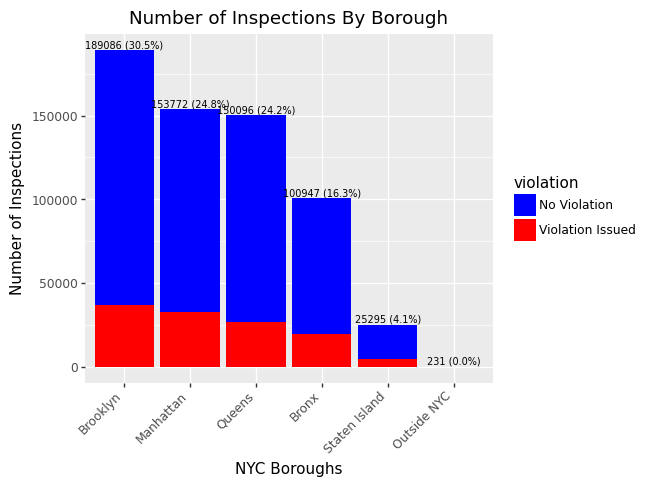

In [45]:
#####-----     Plot Inspections by Borough     -----#####
# Borough counts
boros = np.array(['Bronx','Brooklyn', 'Manhattan', 'Outside NYC', 'Queens', 'Staten Island'])
boroughset = inspections_df.filter(['record_id','borough','violation'], axis=1)
boroughcounts = boroughset.groupby(['borough','violation']).count()

# Count totals
#boroughtotal = boroughcounts.sum(level = 0)
boroughcounts = boroughcounts.unstack()
boroughcounts.columns = boroughcounts.columns.droplevel(level=0)
boroughcounts = boroughcounts.fillna(0)
boroughcounts.sort_values(by=['No Violation'])

# Print Summary
print("*"*80)
print (boroughcounts)
print("*"*80)

# Sorting
borough_list = inspections_df['borough'].value_counts().index.tolist()
borough_cat = pd.Categorical(inspections_df['borough'], categories=borough_list)

# assign to a new column in the DataFrame
inspections_df = inspections_df.assign(borough_cat = borough_cat)

# combine the counts and percentages
def combine(counts, percentages):
    fmt = '{} ({:.1f}%)'.format
    return [fmt(c, p) for c, p in zip(counts, percentages)]

# Plot Bar graph
g = (ggplot(inspections_df, aes('factor(borough_cat)', fill='violation'))         # defining what data to use
 + aes(x= 'borough_cat')    # defining what variable to use
 + geom_bar(size=100) # defining the type of plot to use
 + theme(axis_text_x = element_text(angle = 45, hjust = 1))
 + geom_text(
     aes(label='stat(combine(count, 100*prop))', group=1),
     stat='count', nudge_y=0.125, size=7, va='bottom')
 + labs(title='Number of Inspections By Borough', x='NYC Boroughs', y='Number of Inspections') # customizing labels
 + scale_fill_manual(values = ("Blue","Red"))
)
g.draw()

C:\Users\frnun\AppData\Local\Temp\ipykernel_37892\348613923.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


********************************************************************************
violation  No Violation  Violation Issued
weekday                                  
Friday            87516             20668
Monday            84058             20890
Saturday          19103              4572
Sunday            11569              2524
Thursday          96897             24453
Tuesday           89987             21088
Wednesday        108811             27291
********************************************************************************


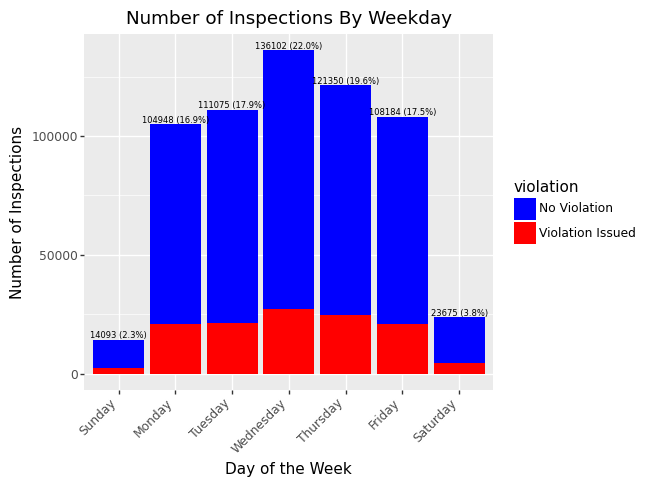

In [46]:
#####-----     Plot Inspections by Day of of the week   -----#####
# Weekday counts
weekdays = np.array(['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
weekset = inspections_df.filter(['record_id','weekday','violation'], axis=1)
weekcounts = weekset.groupby(['weekday','violation']).count()

# Count totals
#weektotal = weekcounts.sum(level=0)
weekcounts = weekcounts.unstack()
weekcounts.columns = weekcounts.columns.droplevel(level=0)
weekcounts = weekcounts.fillna(0)
weekcounts.sort_values(by=['No Violation'])

# Print Summary
print("*"*80)
print (weekcounts)
print("*"*80)
 
# Make Day of the Week Ordered Categorical
inspections_df['weekday'] = pd.Categorical(inspections_df['weekday'], categories=
['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],
ordered=True)

# Plot Bar graph
g = (ggplot(inspections_df, aes('factor(weekday)', fill='violation'))         # defining what data to use
 + aes(x= 'weekday')    # defining what variable to use
 + geom_bar(size=100) # defining the type of plot to use
 + theme(axis_text_x = element_text(angle = 45, hjust = 1))
 + geom_text(
     aes(label='stat(combine(count, 100*prop))', group=1),
     stat='count', nudge_y=0.125, size=6, va='bottom')
 + labs(title='Number of Inspections By Weekday', x='Day of the Week', y='Number of Inspections')
 + scale_fill_manual(values = ("Blue","Red"))
)
g.draw()

C:\Users\frnun\AppData\Local\Temp\ipykernel_37892\3615536207.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


********************************************************************************
violation  No Violation  Violation Issued
year                                     
2014              58681             12159
2015              60563             12491
2016              67298             14668
2017              63620             16650
2018              56205             14252
2019              52091             15992
2020              31711              7122
2021              34909              7651
2022              43904             12184
2023              28959              8317
********************************************************************************


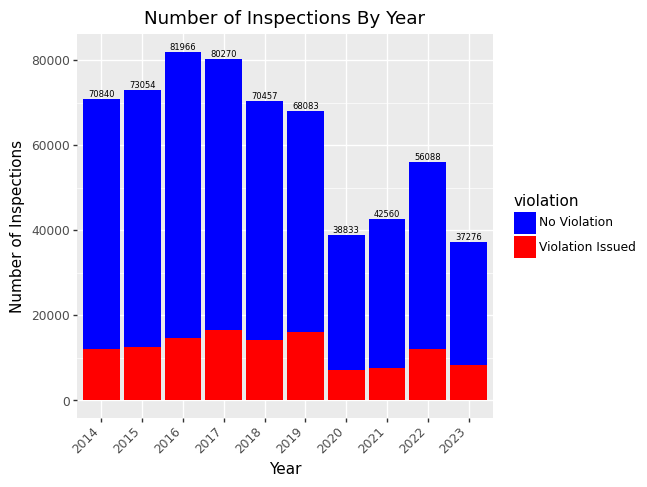

In [47]:
#####-----     Plot Inspections by Year  -----#####
# Year counts
years = np.array(['2017','2018', '2019'])
yearset = inspections_df.filter(['record_id','year','violation'], axis=1)
yearcounts = yearset.groupby(['year','violation']).count()

# Count totals
#yeartotal = yearcounts.sum(level=0)
yearcounts = yearcounts.unstack()
yearcounts.columns = yearcounts.columns.droplevel(level=0)
yearcounts = yearcounts.fillna(0)
yearcounts.sort_values(by=['No Violation'])

# Print Summary
print("*"*80)
print (yearcounts)
print("*"*80)

# Plot Bar graph
g= (ggplot(inspections_df, aes('factor(year)', fill='violation'))         # defining what data to use
 + aes(x= 'year')    # defining what variable to use
 + geom_bar(size=100) # defining the type of plot to use
 + theme(axis_text_x = element_text(angle = 45, hjust = 1))
 + geom_text(
     aes(label='stat(count)', group=1),
     stat='count', nudge_y=0.125, size=6, va='bottom')
 + labs(title='Number of Inspections By Year', x='Year', y='Number of Inspections') # customizing labels
 + scale_fill_manual(values = ("Blue","Red"))
)
g.draw()

C:\Users\frnun\AppData\Local\Temp\ipykernel_37892\1521664793.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


********************************************************************************
violation  No Violation  Violation Issued
month                                    
1                 40563             11385
2                 42522             11319
3                 47249             12020
4                 44435             10492
5                 45711             10729
6                 44823             10222
7                 41995              9312
8                 43741             10039
9                 41495              9954
10                37820              9204
11                31799              7953
12                35788              8857
********************************************************************************


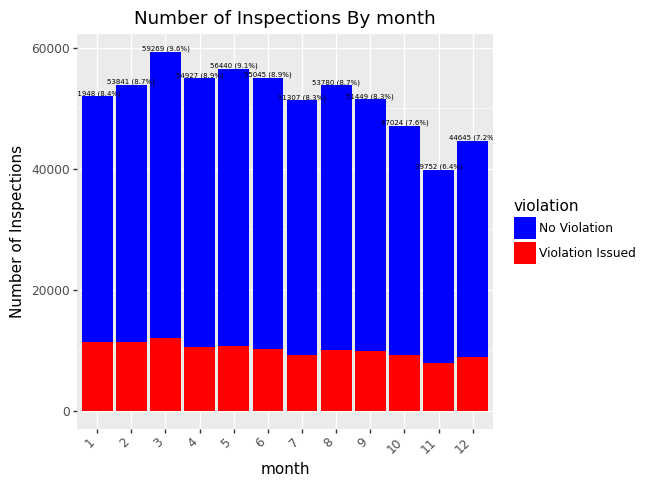

In [48]:
#####-----     Plot Inspections by Month  -----##### 
# Year counts
months = np.array(['1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
monthset = inspections_df.filter(['record_id','month','violation'], axis=1)
monthcounts = monthset.groupby(['month','violation']).count()

# Count totals
#monthtotal = monthcounts.sum(level=0)
monthcounts = monthcounts.unstack()
monthcounts.columns = monthcounts.columns.droplevel(level=0)
monthcounts = monthcounts.fillna(0)
monthcounts.sort_values(by=['No Violation'])

# Print Summary
print("*"*80)
print (monthcounts)
print("*"*80)

g = (ggplot(inspections_df, aes('factor(month)', fill='violation'))         # defining what data to use
 + aes(x= 'month')    # defining what variable to use
 + geom_bar(size=50) # defining the type of plot to use
 + theme(axis_text_x = element_text(angle = 45, hjust = 1))
 + geom_text( aes(label='stat(combine(count, 100*prop))', group=1),
     stat='count', nudge_y=0.125, size=5, va='bottom')
 + labs(title='Number of Inspections By month', x='month', y='Number of Inspections') # customizing labels
 + scale_fill_manual(values = ("Blue","Red"))
)
g.draw()

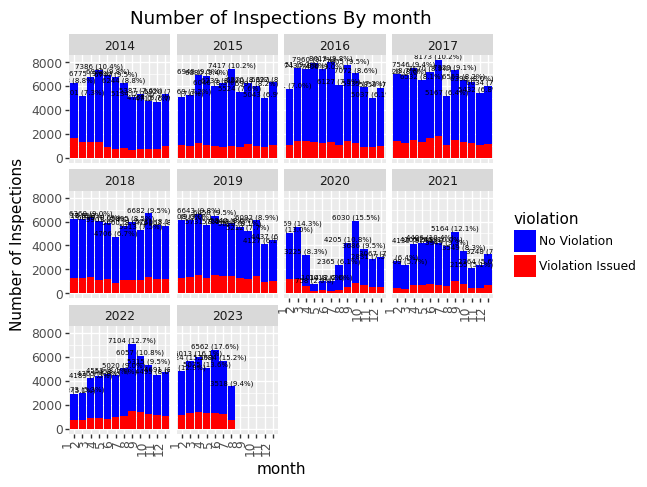

In [49]:
 #####-----     Plot Inspections by Month for each Year -----##### 
g = (ggplot(inspections_df, aes('factor(month)', fill='violation'))         # defining what data to use
 + aes(x= 'month')    # defining what variable to use
 + geom_bar(size=50) # defining the type of plot to use
 + facet_wrap("year")
 + theme(axis_text_x = element_text(angle = 90, hjust = 1))
 + geom_text( aes(label='stat(combine(count, 100*prop))', group=1),
     stat='count', nudge_y=0.125, size=5, va='bottom')
 + labs(title='Number of Inspections By month', x='month', y='Number of Inspections') # customizing labels
+ scale_fill_manual(values = ("Blue","Red"))
)
g.draw()

In [50]:
# Daily comparison per year
#Select the columns we want
dailygroup = inspections_df[['inspection_date', 'borough', 'yrmon', 'year', 'month', 'weekday', 'violation']]
dailygroup['month']=dailygroup.month.astype('int64')

dailygroup['DATE_OF_INSPECTION'] = dailygroup['inspection_date']
dailygroup=dailygroup.set_index('DATE_OF_INSPECTION')
dailygroup = dailygroup.sort_index()

C:\Users\frnun\AppData\Local\Temp\ipykernel_37892\1692745709.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\frnun\AppData\Local\Temp\ipykernel_37892\1692745709.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:
# Create group DFs for each year grouped by date
dailygroup['daily_sum'] = 1
group2018= dailygroup.groupby(dailygroup.index)
df_2018=pd.DataFrame(group2018['daily_sum'].sum())
df_2018['cum_sum'] = df_2018.daily_sum.cumsum()
df_2018['day'] = range(len(df_2018))

group_inspection=dailygroup.groupby(['year'])

df2019=group_inspection.get_group(2019)
group2019= df2019.groupby(df2019.index)
df_2019=pd.DataFrame(group2019['daily_sum'].sum())
df_2019['cum_sum'] = df_2019.daily_sum.cumsum()
df_2019['day'] = range(len(df_2019))
df_2019.insert(3, 'year', '2019')
print(df_2019)

df2018=group_inspection.get_group(2018)
group2018= df2018.groupby(df2018.index)
df_2018=pd.DataFrame(group2018['daily_sum'].sum())
df_2018['cum_sum'] = df_2018.daily_sum.cumsum()
df_2018['day'] = range(len(df_2018))
df_2018.insert(3, 'year', '2018')
print(df_2018)

df2017=group_inspection.get_group(2017)
group2017= df2017.groupby(df2017.index)
df_2017=pd.DataFrame(group2017['daily_sum'].sum())
df_2017['cum_sum'] = df_2017.daily_sum.cumsum()
df_2017['day'] = range(len(df_2017))
df_2017.insert(3, 'year', '2017')
print(df_2017)

                    daily_sum  cum_sum  day  year
DATE_OF_INSPECTION                               
2019-01-02                282      282    0  2019
2019-01-03                246      528    1  2019
2019-01-04                217      745    2  2019
2019-01-05                 81      826    3  2019
2019-01-06                 77      903    4  2019
...                       ...      ...  ...   ...
2019-12-27                139    67720  327  2019
2019-12-28                 53    67773  328  2019
2019-12-29                 42    67815  329  2019
2019-12-30                141    67956  330  2019
2019-12-31                127    68083  331  2019

[332 rows x 4 columns]
                    daily_sum  cum_sum  day  year
DATE_OF_INSPECTION                               
2018-01-02                176      176    0  2018
2018-01-03                293      469    1  2018
2018-01-04                 11      480    2  2018
2018-01-06                 81      561    3  2018
2018-01-07                

C:\Users\frnun\AppData\Local\Temp\ipykernel_37892\1746220181.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\frnun\AppData\Local\Temp\ipykernel_37892\1746220181.py:10: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
C:\Users\frnun\AppData\Local\Temp\ipykernel_37892\1746220181.py:18: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
C:\Users\frnun\AppData\Local\Temp\ipykernel_37892\1746220181.py:26: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to g

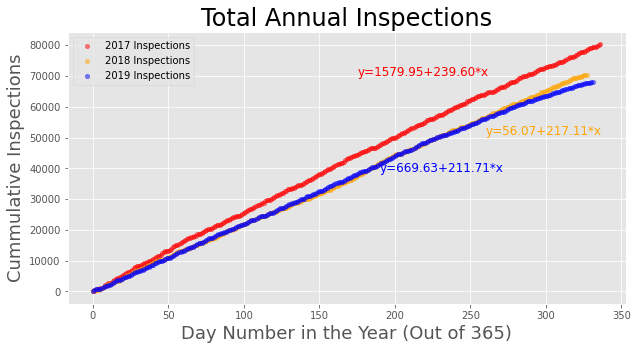

In [52]:
# Creating Plot of Total Inspections in the Year (Using matplotlib.pyplot)

# Scatter plots.
ax1= df_2017.plot(kind='scatter', x='day',y='cum_sum', color='red',alpha=0.5, figsize=(10,5))
df_2018.plot(kind='scatter', x='day',y='cum_sum', color='orange',alpha=0.5, figsize=(10,5),ax=ax1)
df_2019.plot(kind='scatter', x='day',y='cum_sum', color='blue',alpha=0.5, figsize=(10,5),ax=ax1)

#Best fit polynomials for regression lines
df2017_fit = np.polyfit(df_2017.day,df_2017.cum_sum,1) #[ 239.50123034 1603.79033589]
df2018_fit = np.polyfit(df_2018.day,df_2018.cum_sum,1) #[219.41454971 -14.92260933]
df2019_fit = np.polyfit(df_2019.day,df_2019.cum_sum,1) #[217.60771658 299.24636316]

# Regression equations.
plt.text(175,70000,'y={:.2f}+{:.2f}*x'.format(df2017_fit[1],df2017_fit[0]),color='red',size=12)
plt.text(260,51000,'y={:.2f}+{:.2f}*x'.format(df2018_fit[1],df2018_fit[0]),color='orange',size=12)
plt.text(190,39000,'y={:.2f}+{:.2f}*x'.format(df2019_fit[1],df2019_fit[0]),color='blue',size=12)

# Legend, title and labels.
plt.legend(labels=['2017 Inspections','2018 Inspections', '2019 Inspections'])
plt.title('Total Annual Inspections', size=24)
plt.xlabel('Day Number in the Year (Out of 365)', size=18)
plt.ylabel('Cummulative Inspections', size=18);
plt.show()


In [53]:
#YTD Graph Up until end of august
YTDgroup = inspections_df[['inspection_date', 'borough', 'yrmon', 'year', 'month', 'weekday', 'violation']]
YTDgroup['month']=YTDgroup.month.astype('int64')
YTDgroup = YTDgroup[YTDgroup['month']<8]

YTDgroup['DATE_OF_INSPECTION'] = YTDgroup['inspection_date']
YTDgroup=YTDgroup.set_index('DATE_OF_INSPECTION')
YTDgroup = YTDgroup.sort_index()


# Create group DFs
YTDgroup['daily_sum'] = 1
group2018= YTDgroup.groupby(YTDgroup.index)
YTD2018=pd.DataFrame(group2018['daily_sum'].sum())
YTD2018['cum_sum'] = YTD2018.daily_sum.cumsum()
YTD2018['day'] = range(len(YTD2018))

group_inspection=YTDgroup.groupby(['year'])

df2019=group_inspection.get_group(2019)
group2019= df2019.groupby(df2019.index)
YTD2019=pd.DataFrame(group2019['daily_sum'].sum())
YTD2019['cum_sum'] = YTD2019.daily_sum.cumsum()
YTD2019['day'] = range(len(YTD2019))
YTD2019.insert(3, 'year', '2019')
print(YTD2019)
print("*"*80)

df2018=group_inspection.get_group(2018)
group2018= df2018.groupby(df2018.index)
YTD2018=pd.DataFrame(group2018['daily_sum'].sum())
YTD2018['cum_sum'] = YTD2018.daily_sum.cumsum()
YTD2018['day'] = range(len(YTD2018))
YTD2018.insert(3, 'year', '2018')
print(YTD2018)
print("*"*80)

df2017=group_inspection.get_group(2017)
group2017= df2017.groupby(df2017.index)
YTD2017=pd.DataFrame(group2017['daily_sum'].sum())
YTD2017['cum_sum'] = YTD2017.daily_sum.cumsum()
YTD2017['day'] = range(len(YTD2017))
YTD2017.insert(3, 'year', '2017')
print(YTD2017)
print("*"*80)


C:\Users\frnun\AppData\Local\Temp\ipykernel_37892\1123483988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                    daily_sum  cum_sum  day  year
DATE_OF_INSPECTION                               
2019-01-02                282      282    0  2019
2019-01-03                246      528    1  2019
2019-01-04                217      745    2  2019
2019-01-05                 81      826    3  2019
2019-01-06                 77      903    4  2019
...                       ...      ...  ...   ...
2019-07-25                288    41645  191  2019
2019-07-26                159    41804  192  2019
2019-07-29                264    42068  193  2019
2019-07-30                280    42348  194  2019
2019-07-31                347    42695  195  2019

[196 rows x 4 columns]
********************************************************************************
                    daily_sum  cum_sum  day  year
DATE_OF_INSPECTION                               
2018-01-02                176      176    0  2018
2018-01-03                293      469    1  2018
2018-01-04                 11      480    2  

C:\Users\frnun\AppData\Local\Temp\ipykernel_37892\1123483988.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\frnun\AppData\Local\Temp\ipykernel_37892\1123483988.py:20: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
C:\Users\frnun\AppData\Local\Temp\ipykernel_37892\1123483988.py:29: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
C:\Users\frnun\AppData\Local\Temp\ipykernel_37892\1123483988.py:38: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

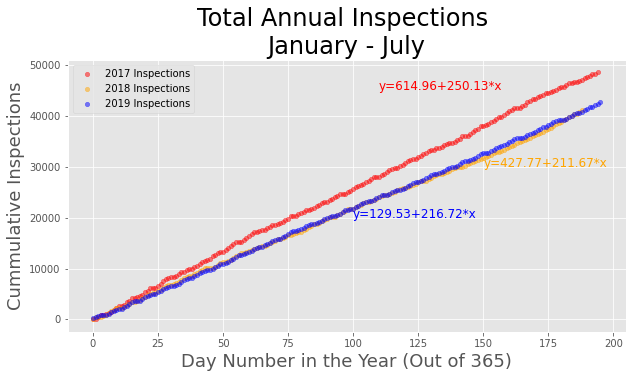

In [54]:
# Creating Plot of Total Inspections in the Year

# Scatter plots.
ax1= YTD2017.plot(kind='scatter', x='day',y='cum_sum', color='red',alpha=0.5, figsize=(10,5))
YTD2018.plot(kind='scatter', x='day',y='cum_sum', color='orange',alpha=0.5, figsize=(10,5),ax=ax1)
YTD2019.plot(kind='scatter', x='day',y='cum_sum', color='blue',alpha=0.5, figsize=(10,5),ax=ax1)

#Best fit polynomials for regression lines
YTD2017_fit = np.polyfit(YTD2017.day,YTD2017.cum_sum,1) #[248.54346118 733.58163837]
YTD2018_fit = np.polyfit(YTD2018.day,YTD2018.cum_sum,1) #[217.31322235 144.54155999]
YTD2019_fit = np.polyfit(YTD2019.day,YTD2019.cum_sum,1) #[217.60771658 299.24636316]

# Regression equations.
plt.text(110,45000,'y={:.2f}+{:.2f}*x'.format(YTD2017_fit[1],YTD2017_fit[0]),color='red',size=12)
plt.text(150,30000,'y={:.2f}+{:.2f}*x'.format(YTD2018_fit[1],YTD2018_fit[0]),color='orange',size=12)
plt.text(100,20000,'y={:.2f}+{:.2f}*x'.format(YTD2019_fit[1],YTD2019_fit[0]),color='blue',size=12)

# Legend, title and labels.
plt.legend(labels=['2017 Inspections','2018 Inspections', '2019 Inspections'])
plt.title('Total Annual Inspections \nJanuary - July', size=24)
plt.xlabel('Day Number in the Year (Out of 365)', size=18)
plt.ylabel('Cummulative Inspections', size=18);
plt.show()

In [55]:
#Mapping Datasets - Tobacco Inspections for July 2019

# Pull Violations Data 
violations_df = inspections_df[(inspections_df['inspection_result']=='Violation Issued')]
violations_df = violations_df[(violations_df['industry']=='Tobacco Retail Dealer')]
#violations_df = violations_df[(violations_df['industry']=='Tobacco Retail Dealer') | (violations_df['industry']=='Grocery-Retail')]
violations_df = violations_df[(violations_df['year']==2019) & (violations_df['month']==7)]
#violations_df = violations_df[(violations_df['year']==2019)]
violations_df = violations_df[['latitude', 'longitude','business_name','industry']]
violations_df = violations_df.dropna(axis=0, subset=['latitude','longitude'])

# Pull Inspec Data
nov_df = inspections_df[inspections_df['inspection_result']!='Violation Issued']
nov_df = nov_df[(nov_df['industry']=='Tobacco Retail Dealer')]
#nov_df = nov_df[(nov_df['industry']=='Tobacco Retail Dealer') | (nov_df['industry']=='Grocery-Retail')]
nov_df = nov_df[(nov_df['year']==2019) & (nov_df['month']==7)]
#nov_df = nov_df[(nov_df['year']==2019)]
nov_df = nov_df[['latitude', 'longitude','business_name','industry']]
nov_df = nov_df.dropna(axis=0, subset=['latitude','longitude'])

# NYCmap
nycmap = folium.Map(
    location=[40.713050, -74.007230],
    zoom_start=11)

# Add Violations marker one by one on the map
for i in range(0,len(violations_df)):
    folium.Marker([violations_df.iloc[i]['latitude'],
                   violations_df.iloc[i]['longitude']],
                  popup=(violations_df.iloc[i]['business_name'], violations_df.iloc[i]['industry']),
                  icon=folium.Icon(color='red', icon='remove')
                 ).add_to(nycmap)
    
# Add Non-Violations marker one by one on the map
for i in range(0,len(nov_df)):
    folium.Marker([nov_df.iloc[i]['latitude'],
                   nov_df.iloc[i]['longitude']],
                  popup=(nov_df.iloc[i]['business_name'], nov_df.iloc[i]['industry']),
                  icon=folium.Icon(color='blue', icon='thumbs-up')
                 ).add_to(nycmap)

print("*"*80)
print("Generating Tobacco Inspections Map for July 2019")
print("Plotting", len(violations_df), "Violation Tobacco Inspections")
print("Plotting", len(nov_df), "Non-Violation Tobacco inspections")
print("Click individual markers on the map for details")
print("*"*80)
nycmap

********************************************************************************
Generating Tobacco Inspections Map for July 2019
Plotting 236 Violation Tobacco Inspections
Plotting 915 Non-Violation Tobacco inspections
Click individual markers on the map for details
********************************************************************************


In [56]:
output_file = "inspectionsmap.html"
map = nycmap
map.save(output_file)
webbrowser.open(output_file, new=2)

True